# 计算物理B第六次作业--第四题

PB20511896 王金鑫

### 题目描述

用分子动力学方法模拟64个粒子的运动

In [31]:
# !/usr/bin/env python
# -*- coding: utf-8 -*-

# ----------------------------------------------------------------
# @copyright (C), 2022, Bruce Wong, All rights reserved.
# @File Name   : MD.ipynb
# @Author      : Bruce Wong
# @Version     : 
# @Date        : 2022-11-13 14:50:41
# @Description : 
# 
# Molecular dynamics (MD), using Lennard-Jones potential and 
# Verlet algorithm.
# 
# Only supporting cubic space now.
#
# ----------------------------------------------------------------



### 导入库

In [32]:
import random
from math import cos, sin, pi, sqrt, acos
import matplotlib.pyplot as plt


### 定义参数


In [33]:
epsilon, sigma = 1, 1
Lx, Ly = 10, 10
Ngrid = 10
Npar = 64
m = 1
# boltzmann const
k = 1

# step length
delta_t = 0.02
h = delta_t
# 100~200 steps

### 定义函数和类

计算粒子之间的距离

In [34]:
# distence between two particles
def ParticleDistence(par1, par2):
    return sqrt((par1.x-par2.x)**2+(par1.y-par2.y)**2)


绘制粒子空间位置

In [35]:
def PlotParXY(cell):
    x, y = [], []
    for par in cell.pars:
        x.append(par.x)
        y.append(par.y)

    # fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"})
    fig = plt.figure()
    aspect='equal'
    ax1 = fig.add_subplot(111)
    # ax1 = ax[0]
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.scatter(x, y)
    

粒子类

In [36]:
class Particle2D(object):
    Fx, Fy = 0, 0
    # potential energy
    PE = 0
    # def __init__(self, x=0, y=0, z=0, V=0, theta=0, phi=0, m=1) -> None:
    def __init__(self, x=0, y=0, vx=0, vy=0, m=1) -> None:
        self.x, self.y = x, y
        # self.V, self.theta, self.phi = V, theta, phi
        # self.vx, self.vy, self.vz = V*sin(phi)*cos(theta), V*sin(phi)*sin(theta), V*cos(phi)
        self.vx, self.vy = vx, vy
        self.V = sqrt(vx**2+vy**2)
        if (0==self.V):
            self.theta = 0
        else:
            self.theta = acos(vx/(self.V))
        # mass
        self.m = m
        # KineticEnergy
        self.KE = 0.5 * self.m * (self.V)**2
    def updateXY(self, x, y):
        self.x, self.y = x, y
    def updateVTheta(self, V, theta):
        self.V, self.theta = V, theta
        self.vx, self.vy = V*cos(theta), V*sin(theta)
    def updateVxy(self, vx, vy):
        self.vx, self.vy = vx, vy
        self.V = sqrt(vx**2+vy**2)
        self.theta = acos(vx/(self.V))
    def updateKE(self):
        self.KE = 0.5 * self.m * (self.V**2)
    def updatePE(self, PE):
        self.PE = PE


Lennard-Jones势类

In [37]:
class LennardJonesPotential(object):
    def __init__(self, eplsion=1, sigma=1) -> None:
        self.epsilon = eplsion
        self.sigma = sigma
    def potential(self, r):
        return 4*self.epsilon*(pow(self.sigma/r, 12) - pow(self.sigma/r, 6))
    def force_X(self, par1, par2):
        # the force par1 got
        r = ParticleDistence(par1, par2)
        if (0 == r):
            print("Error: Caculate force between the two same particles.")
            print(par1.x,"\t",par1.y,"\t",r)
            exit(-1)
        else:
            Fx = (48*(self.epsilon/self.sigma/self.sigma)*
            (par1.x-par2.x)*(pow(self.sigma/r, 14) - 0.5*pow(self.sigma/r, 8)))
            # for debugging
            if (Fx>100):
                print("Error: Fx>100")
                print("r =",r)
                print(par1.x, par1.y)
                print(par2.x, par2.y)
                exit(-1)
            return Fx
    def force_Y(self, par1, par2):
        # the force par1 got
        r = ParticleDistence(par1, par2)
        if (0 == r):
            print("Error: Caculate force between the two same particles.")
            exit(-1)
        else:
            return (48*(self.epsilon/self.sigma/self.sigma)*
            (par1.y-par2.y)*(pow(self.sigma/r, 14) - 0.5*pow(self.sigma/r, 8)))


计算粒子受到的总力和总势能


In [38]:
def AllForceAndPE(par, pars, potential):
    Fx, Fy = 0, 0
    PE = 0

    for pari in pars:
        # buffer
        parBuffer = Particle2D(
            pari.x, 
            pari.y, 
            m=pari.m
            )

        # check if is the same
        if (par.x==parBuffer.x and par.y==parBuffer.y):
            continue
        # check if need mirror
        if (parBuffer.x-par.x > Lx/2):
            parBuffer.x -= Lx
        elif (par.x-parBuffer.x > Lx/2):
            parBuffer.x += Lx
        if (parBuffer.y-par.y > Ly/2):
            parBuffer.y -= Ly
        elif (par.y-parBuffer.y > Ly/2):
            parBuffer.y += Ly
        # check if is the same
        if (par.x==parBuffer.x and par.y==parBuffer.y):
            continue

        Fx += potential.force_X(par, parBuffer)
        Fy += potential.force_Y(par, parBuffer)
        PE += potential.potential(ParticleDistence(par, parBuffer))
        
    return Fx, Fy, PE


元胞类

In [39]:
class Cell3D(object):
    def __init__(self, Lx, Ly, Ngrid, Npar, Mpar) -> None:
        # length of cell
        self.Lx, self.Ly = Lx, Ly
        # number of particle
        self.Npar = Npar
        # particles
        # this way of generation is the requirement of the homework.
        self.pars = []
        
        gridpoints = [[0 for j in range(10)] for i in range(10)]
        for i in range(Npar):
            x = int(random.uniform(0, Ngrid))*Lx/Ngrid
            y = int(random.uniform(0, Ngrid))*Ly/Ngrid 
            while (1==gridpoints[int(x)][int(y)]):
                x = int(random.uniform(0, Ngrid))*Lx/Ngrid
                y = int(random.uniform(0, Ngrid))*Ly/Ngrid 
            # mark particle
            # 1 for exist particle
            # for avoiding generate two particle at the same place
            gridpoints[int(x)][int(y)] = 1

            self.pars.append(Particle2D(
                x, 
                y,  
                random.uniform(-1,1), 
                random.uniform(-1,1), 
                Mpar
                ))
            
    

### 定义系统

In [40]:
cell = Cell3D(Lx, Ly, Ngrid, Npar, m)
potential = LennardJonesPotential()


确定系综

`condition=1` 表示微正则系综，能量守恒

`condition=2` 表示正则系综，温度守恒


In [41]:
# temperature
T = 0.85

condition = 2

### 开始模拟并生成动画和图像

这里我们使用Verlet速度形式算法:
$$\boldsymbol{r}^{(n+1)}_i = \boldsymbol{r}^{(n)}_i+h\boldsymbol{v}^{(n)}_i+\frac{\boldsymbol{F}^{(n)}_ih^2}{2m}$$
$$\boldsymbol{v}^{(n+1)}_i = \boldsymbol{v}^{(n)}_i+\frac{h(\boldsymbol{F}^{(n+1)}_i+\boldsymbol{F}^{(n)}_i)}{2m}$$

In [42]:
# caculate F^(0) and PE
for par in cell.pars:
    par.Fx, par.Fy, par.PE = AllForceAndPE(par, cell.pars, potential)

def iteration(Es, KEs, PEs):
    # Total Energy
    TotalE, TotalPE, TotalKE = 0, 0, 0
    
    # update r
    for par in cell.pars:
        x = par.x + h*par.vx + par.Fx*h*h/(2*m)
        y = par.y + h*par.vy + par.Fy*h*h/(2*m)

        # check if particle is out of the zone
        # for debugging
        x0 = x
        # while (x<0 or x>Lx):
        #     if (x<0):
        #         x += Lx*(1+int(-x/Lx))
        #     else:
        #         x -= Lx*(int(x/Lx))
        # x = x%Lx
        if (x<0):
            x += Lx
        elif (x>Lx):
            x -= Lx
        # for debugging
        if (x<0 or x>Lx):
            print("update x Error")
            print(x0,x,int(x0/Lx))
            print(par.Fx, par.Fy, par.PE)
            print(par.V, par.vx, par.vy)
            return -1
        if (y<0):
            y += Ly
        elif (y>Ly):
            y -= Ly
        # y = y%Ly
        # while (y<0 or y>Ly):
        #     if (y<0):
        #         y += Ly*(1+int(-y/Ly))
        #     else:
        #         y -= Ly*(int(y/Ly))
            
        par.updateXY(x,y)
    # update v and PE
    for par in cell.pars:
        Fx1, Fy1, par.PE = AllForceAndPE(par, cell.pars, potential)
        vx = par.vx + (Fx1+par.Fx)*h/(2*m)
        vy = par.vy + (Fy1+par.Fy)*h/(2*m)
        par.updateVxy(vx,vy)
        par.Fx, par.Fy = Fx1, Fy1
    # fix velocity and update KE
    # and caculate Total Energy
    if (1==condition):
        # Energy consistent
        sum_v2 = 0
        for par in cell.pars:
            sum_v2 += par.V**2
        beta = sqrt(T*(Npar-1)/sum_v2)/4
    elif (2==condition):
        # Temperature consistent
        sum_mv2 = 0
        for par in cell.pars:
            sum_mv2 += par.m*par.V**2
        beta = sqrt(k*T*(3*Npar-4)/sum_mv2)

    for par in cell.pars:
        par.updateVxy(par.vx*beta, par.vy*beta)
        par.updateKE()
        TotalKE += par.KE
        TotalPE += par.PE

    TotalE = TotalKE + TotalPE
    Es.append(TotalE)
    KEs.append(TotalKE)
    PEs.append(TotalPE)



迭代

绘制动能、势能和总能量随时间步的变化

生成动画

In [43]:
# caculate initial energy
systemKE, systemPE, systemE = [], [], []
KEs, PEs, Es = 0, 0, 0
for par in cell.pars:
    KEs += par.KE
    PEs += par.PE
    Es += (KEs+PEs)
systemKE.append(KEs)
systemPE.append(PEs)
systemE.append(Es)


注：这里输出中可能会有 `Error: Fx>100` 。

这只是用于debug的输出，实际上出现 Fx>100 是正常的。

MovieWriter ffmpeg unavailable; using Pillow instead.


nframe=0
nframe=0
Error: Fx>100
r = 0.9062183366134677
8.56234955045608 0.5455919554465206
7.81248687574844 0.036732797432454806
Error: Fx>100
r = 0.8995781105643778
0.4371194968155763 4.985309927875647
-0.45752052354024286 5.0794375592296515
Error: Fx>100
r = 0.896309651182179
9.351470300157745 5.471533711922963
8.502888042668816 5.760114970977174
Error: Fx>100
r = 0.904803230185016
7.246157280886338 5.19477584152919
6.42367633418103 4.8176896741085615
Error: Fx>100
r = 0.9108608837461569
1.608873266160224 4.412589091520643
0.7829734671752684 4.796720672590776
Error: Fx>100
r = 0.9078080932270106
1.7723048512576647 2.153659067354631
0.9695410758369911 2.5775527509603284
Error: Fx>100
r = 0.9108309249950624
2.1585551276636075 5.067534293020201
1.261709006354903 5.2265311754452775
Error: Fx>100
r = 0.9157453031864332
4.837826807079055 6.337241140478992
3.9490464726242953 6.116653340738167


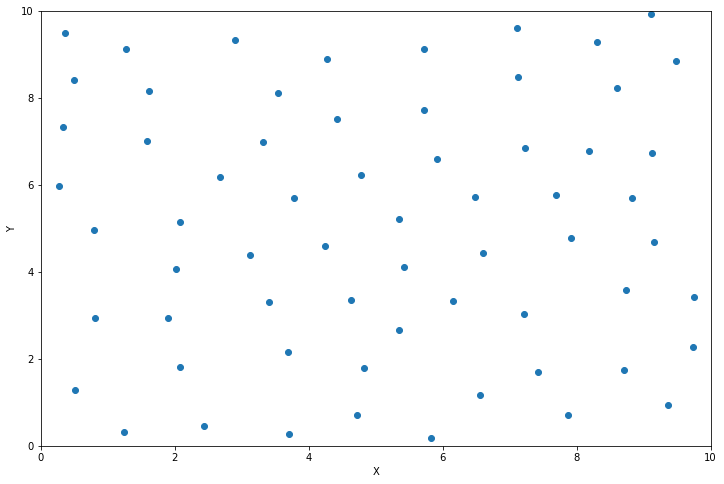

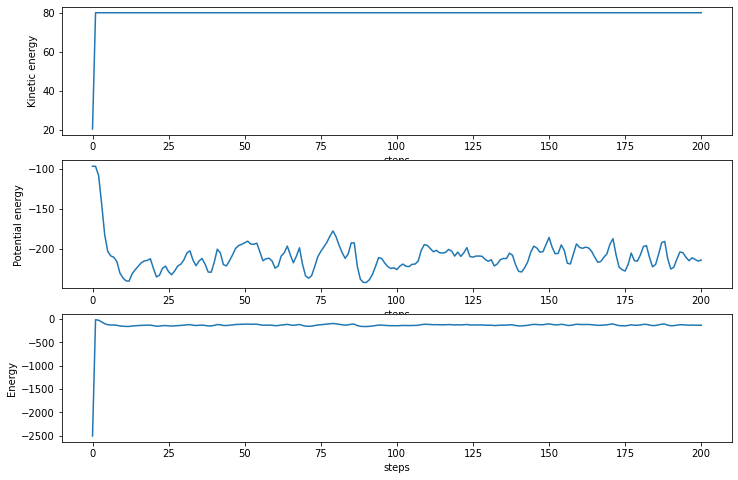

In [44]:


# animation
from matplotlib import animation
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()


def animate(nframe):
    if (nframe==0):
        print("nframe=0")
    elif (nframe==200):
        print("nframe=200")
    elif (nframe==201):
        print("nframe=201")
    if (-1==iteration(systemE, systemKE, systemPE)):
        print("update x Error")
        print(nframe)
        exit(-1)
    # plt.xlim(0, Lx)
    # plt.ylim(0, Ly)
    Xs, Ys = [], []
    for par in cell.pars:
        Xs.append(par.x)
        Ys.append(par.y)

    # plt.cla()
    ax.cla()
    ax.set_xlim(0, Lx)
    ax.set_ylim(0, Ly)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.scatter(Xs, Ys)
anim = animation.FuncAnimation(fig, animate, frames=199)
# anim.save("animation.gif", fps=800)
# anim.save("fps800.gif", fps=800)
anim.save("2dfps200.gif", fps=200)


# 2D line
Nsteps = [i for i in range(201)]

fig1, ax1 = plt.subplots(3, 1, figsize=(12,8))
axKE, axPE, axE = ax1[0], ax1[1], ax1[2]

axKE.set_xlabel("steps")
axKE.set_ylabel("Kinetic energy")
# axKE.set_title('')
axKE.plot(Nsteps, systemKE)

axPE.set_xlabel("steps")
axPE.set_ylabel("Potential energy")
axPE.plot(Nsteps, systemPE)

axE.set_xlabel("steps")
axE.set_ylabel("Energy")
axE.plot(Nsteps, systemE)

plt.show()


生成的动画效果如下

![gif](2dfps200.gif)

绘制最终速度分布图(归一化之后)并与Maxwell-Boltzmann分布做对比

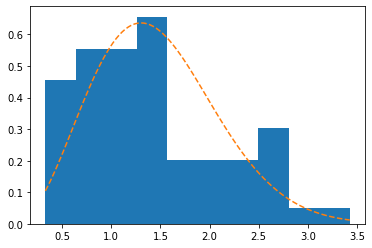

In [45]:
# collect velocity of particles
parVs = []
for par in cell.pars:
    parVs.append(par.V)

fig2 = plt.figure()
ax2 = fig2.add_subplot()
n, bins, patches = ax2.hist(parVs, bins=10, density=True)

import numpy as np
# Maxwell-Boltzmann distribution line
bins = np.linspace(bins.min(), bins.max(), 100)
y = np.power(sqrt(m/(2*np.pi*k*T)), 3)*4*np.pi*bins*bins*np.exp(-m*bins*bins/(2*k*T))
ax2.plot(bins, y, ls="--")

plt.show()


可看出速度分布近似为Maxwell-Boltzmann分布